In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats
import gensim
from gensim import corpora, models
from nltk.corpus import stopwords
from collections import Counter
import folium
from folium import plugins
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("/home/artur/Desktop/Food_Inspections.csv")


In [6]:
df.rename(columns={"License #": "license"}, inplace=True)
df['year'] = pd.DatetimeIndex(df['Inspection Date']).year
df['month'] = pd.DatetimeIndex(df['Inspection Date']).month
df['day'] = pd.DatetimeIndex(df['Inspection Date']).day

df.head()

,Inspection ID,DBA Name,AKA Name,license,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Location,year,month,day
0,2587117,ROLLS N BOWLS EXPRESS,ROLLS N BOWLS EXPRESS,2163786.0,Restaurant,Risk 1 (High),4635 N LINCOLN AVE,CHICAGO,IL,60625.0,12/18/2023,Non-Inspection,No Entry,NaN,41.965884,-87.686601,"(41.965883851821715, -87.68660115678574)",2023,12,18
1,2586991,KENSINGTON SCHOOL OF LINCOLN PARK,KENSINGTON SCHOOL OF LINCOLN PARK,2944036.0,Children's Services Facility,Risk 1 (High),2745 N LINCOLN AVE,CHICAGO,IL,60614.0,12/14/2023,License,Not Ready,NaN,41.931779,-87.657407,"(41.93177936843524, -87.65740695216547)",2023,12,14
2,2587010,BITTERSWEET,BITTERSWEET,2923803.0,Restaurant,Risk 1 (High),2019 S LAFLIN ST,CHICAGOO,IL,60608.0,12/15/2023,License Re-Inspection,Pass w/ Conditions,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,41.854493,-87.663530,"(41.854493434030644, -87.66352975090798)",2023,12,15
3,2586851,AU CHEVAL,AU CHEVAL,2120653.0,Restaurant,Risk 1 (High),800 W RANDOLPH ST,CHICAGO,IL,60607.0,12/13/2023,Canvass,Pass,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPLI...,41.884515,-87.647497,"(41.88451545836221, -87.64749730032112)",2023,12,13
4,2586837,SEGNATORE,SEGNATORE,2786131.0,Restaurant,Risk 1 (High),1001 N CALIFORNIA AVE,CHICAGO,IL,60622.0,12/13/2023,Canvass,Pass,NaN,41.899331,-87.696645,"(41.899330918472295, -87.69664492473737)",2023,12,13


In [7]:
# df = df[df['Inspection Type'].notna()]
# df = df[df['Inspection Type']=='Canvass']
df.dtypes


Inspection ID        int64
DBA Name            object
AKA Name            object
license            float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Results             object
Violations          object
Latitude           float64
Longitude          float64
Location            object
year                 int32
month                int32
day                  int32
dtype: object

In [8]:
df.dropna(subset=["Inspection Date", "license", "Latitude", "Longitude"], inplace=True)
df = df[~df.Results.isin(["Out of Business", "Business Not Located", "No Entry", "Not Ready"])]
len(set(df['DBA Name'].tolist()))
df['DBA Name'].value_counts()[:10]

DBA Name
SUBWAY                          3259
DUNKIN DONUTS                   1719
MCDONALD'S                       695
7-ELEVEN                         472
CHIPOTLE MEXICAN GRILL           410
MCDONALDS                        364
POTBELLY SANDWICH WORKS LLC      348
POTBELLY SANDWICH WORKS          314
DUNKIN DONUTS/BASKIN ROBBINS     298
CORNER BAKERY CAFE               284
Name: count, dtype: int64

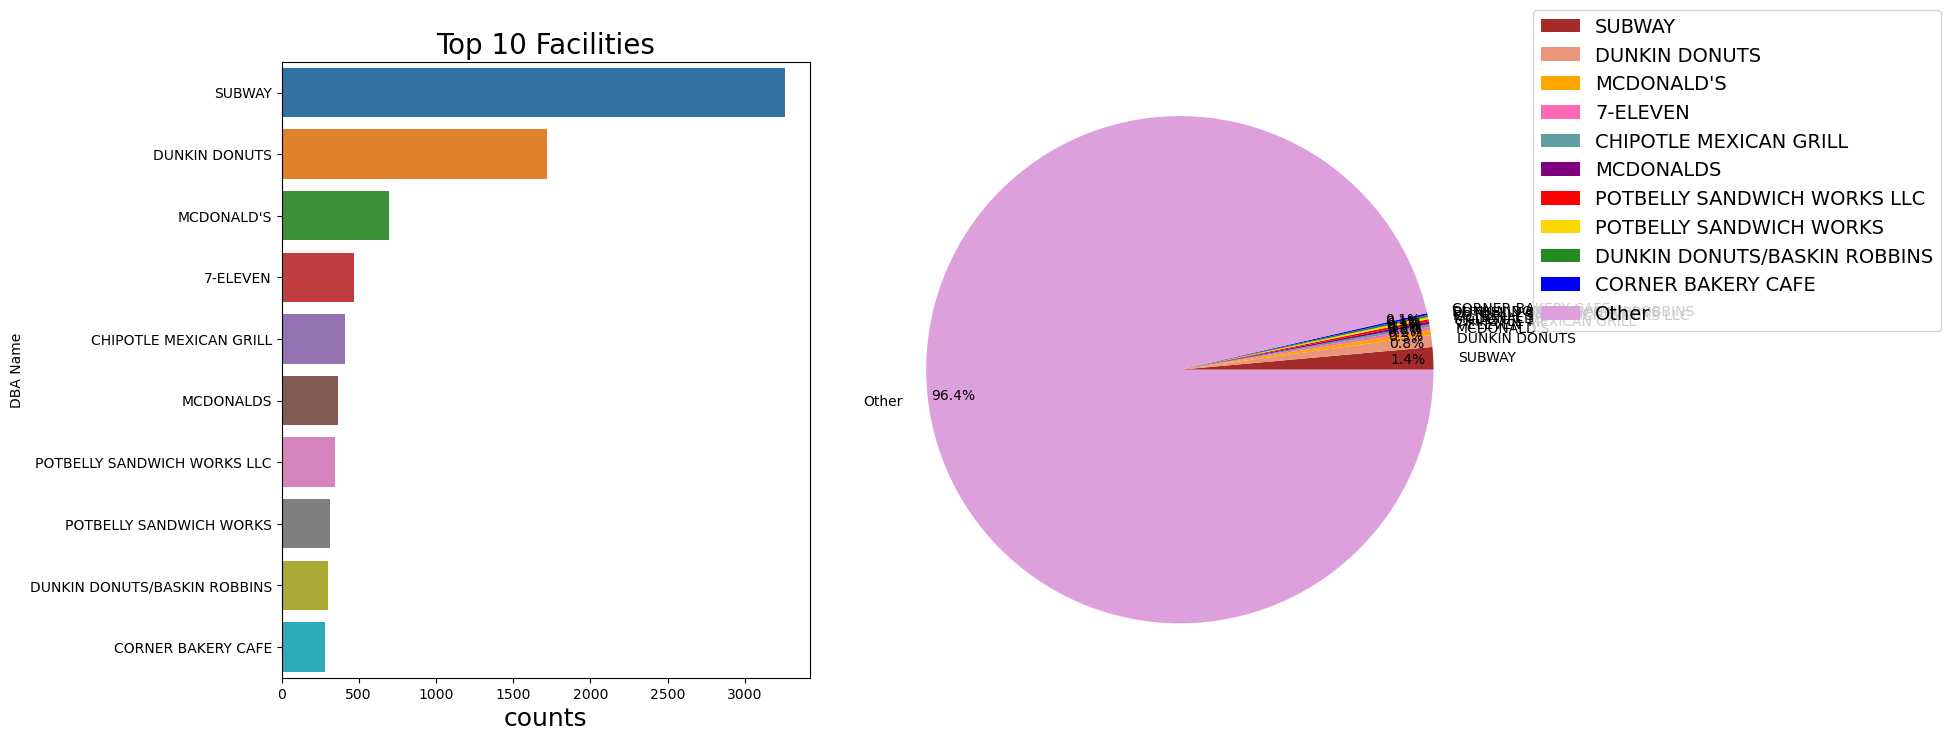

In [9]:
data_risk1=df
fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=data_risk1['DBA Name'].value_counts()[:10],y=data_risk1['DBA Name'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facilities",size=20)
ax[0].set_xlabel('counts',size=18)

count=data_risk1.groupby(['DBA Name'])['Inspection ID'].agg('count').sort_values(ascending=False)
groups=list(data_risk1.groupby(['DBA Name'])['Inspection ID'].agg('count').sort_values(ascending=False).index[:10])
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
ax[1].set_ylabel('')
ax[1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,1.2))

Text(0, 0.5, 'LATITUDE')

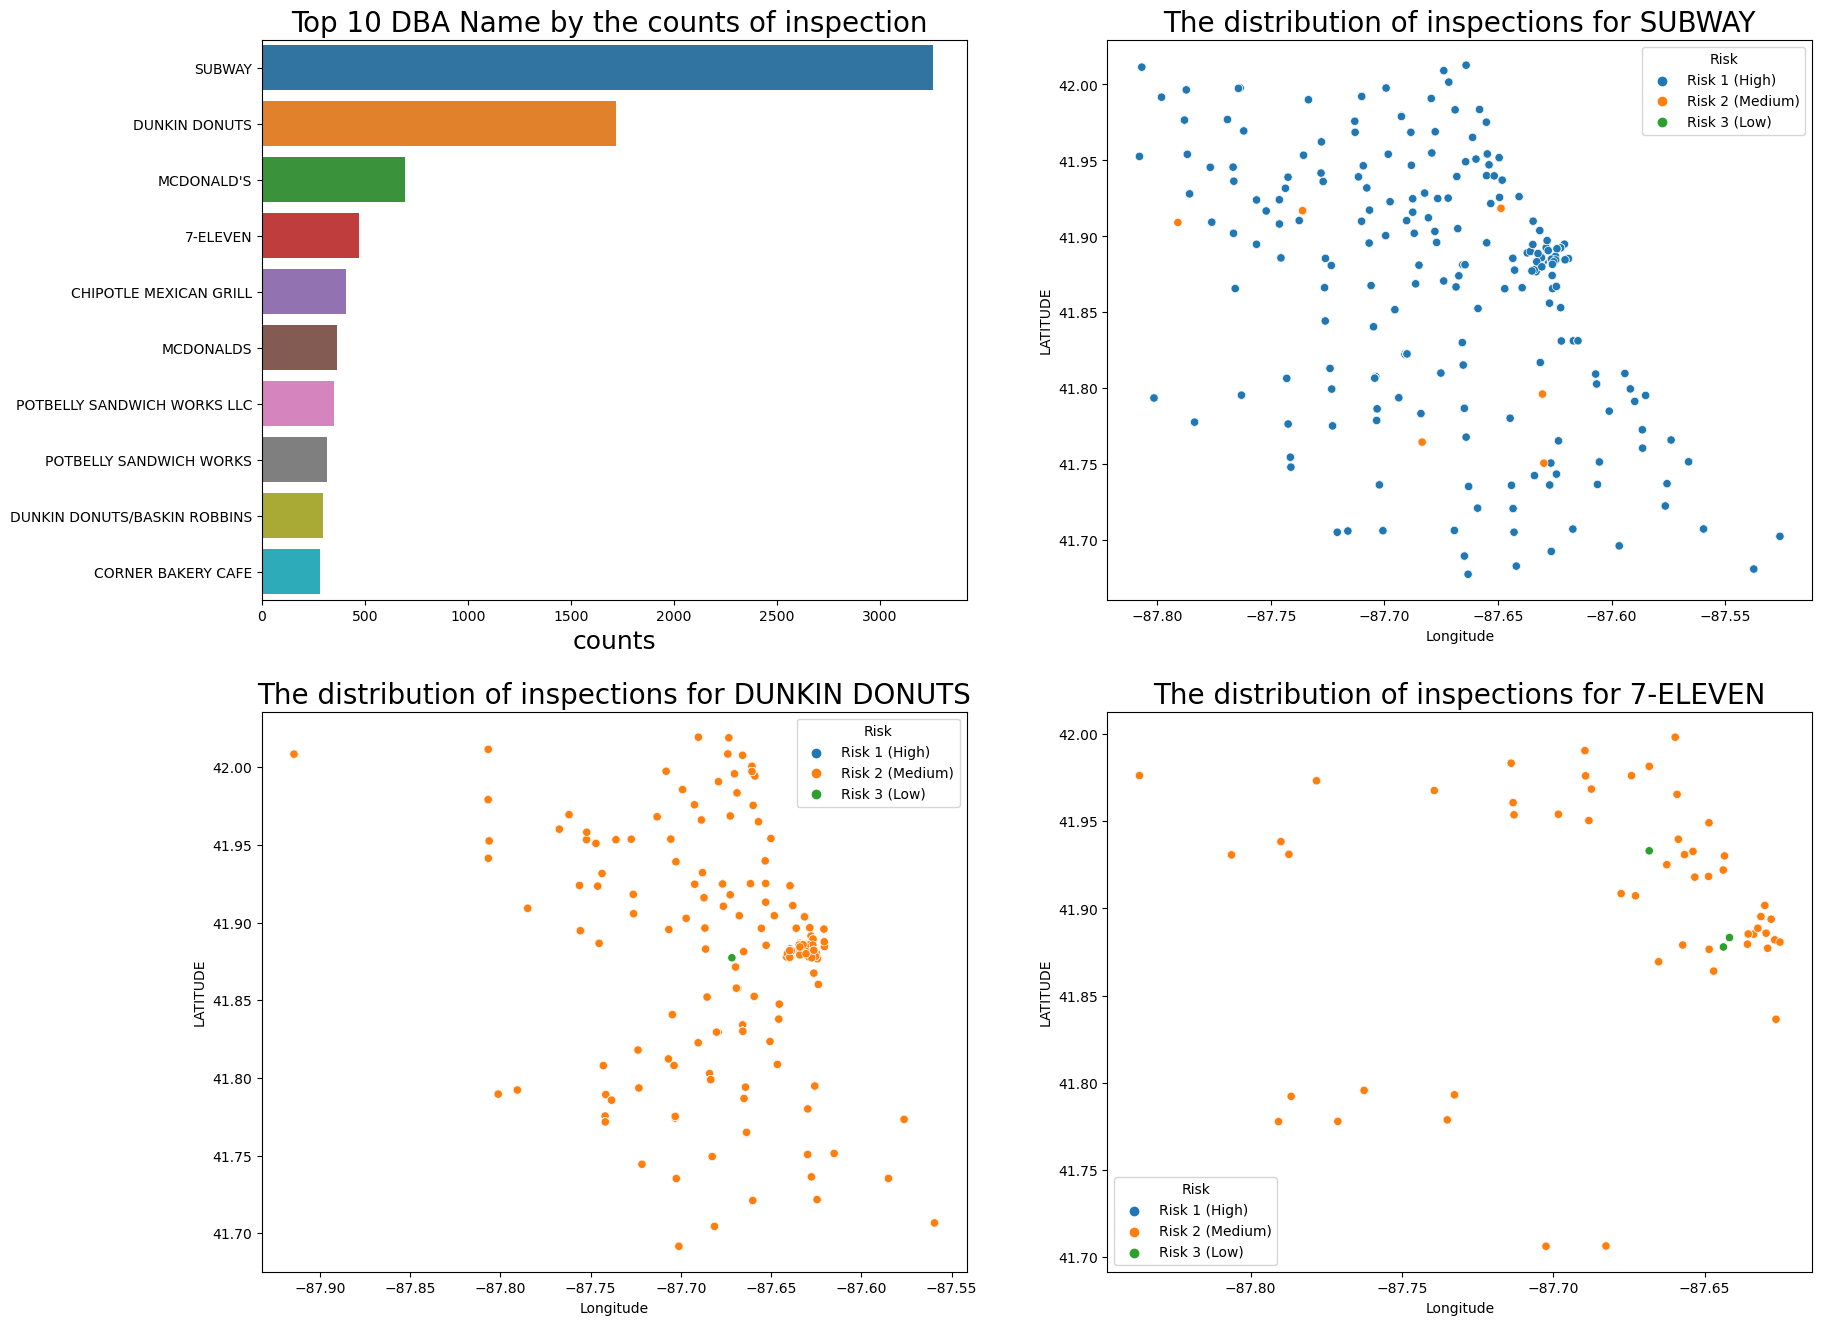

In [10]:
fig,ax=plt.subplots(2,2,figsize=(20,16))
y=df['DBA Name'].value_counts()[:10].index
x=df['DBA Name'].value_counts()[:10]
sns.barplot(x=x,y=y,ax=ax[0,0])
ax[0,0].set_title("Top 10 DBA Name by the counts of inspection ",size=20)
ax[0,0].set_xlabel('counts',size=18)
ax[0,0].set_ylabel('')

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk',hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'] ,data=df[df['DBA Name']=='SUBWAY'], ax=ax[0,1])
ax[0,1].set_title("The distribution of inspections for SUBWAY",size=20)
ax[0,1].set_xlabel('Longitude')
ax[0,1].set_ylabel('LATITUDE')

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk' ,hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'],data=df[df['DBA Name']=='DUNKIN DONUTS'], ax=ax[1,0])
ax[1,0].set_title("The distribution of inspections for DUNKIN DONUTS",size=20)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('LATITUDE')

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk',hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'] ,data=df[df['DBA Name']=='7-ELEVEN'], ax=ax[1,1])
ax[1,1].set_title("The distribution of inspections for 7-ELEVEN",size=20)
ax[1,1].set_xlabel('Longitude')
ax[1,1].set_ylabel('LATITUDE')

In [11]:
len(set(df['license'].tolist()))


38898

In [12]:
len(set(df['Facility Type'].tolist()))


491

In [13]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Assuming df is your DataFrame
x = df['Facility Type'].value_counts().index.values.astype('str')[:10]
y = df['Facility Type'].value_counts().values[:10]
pct = [("%.2f"%(v*100))+"%" for v in (y/len(df))][:10]

trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Facility Type',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Facility Type'))
fig = dict(data=[trace1], layout=layout)
iplot(fig)


Text(0, 0.5, 'LATITUDE')

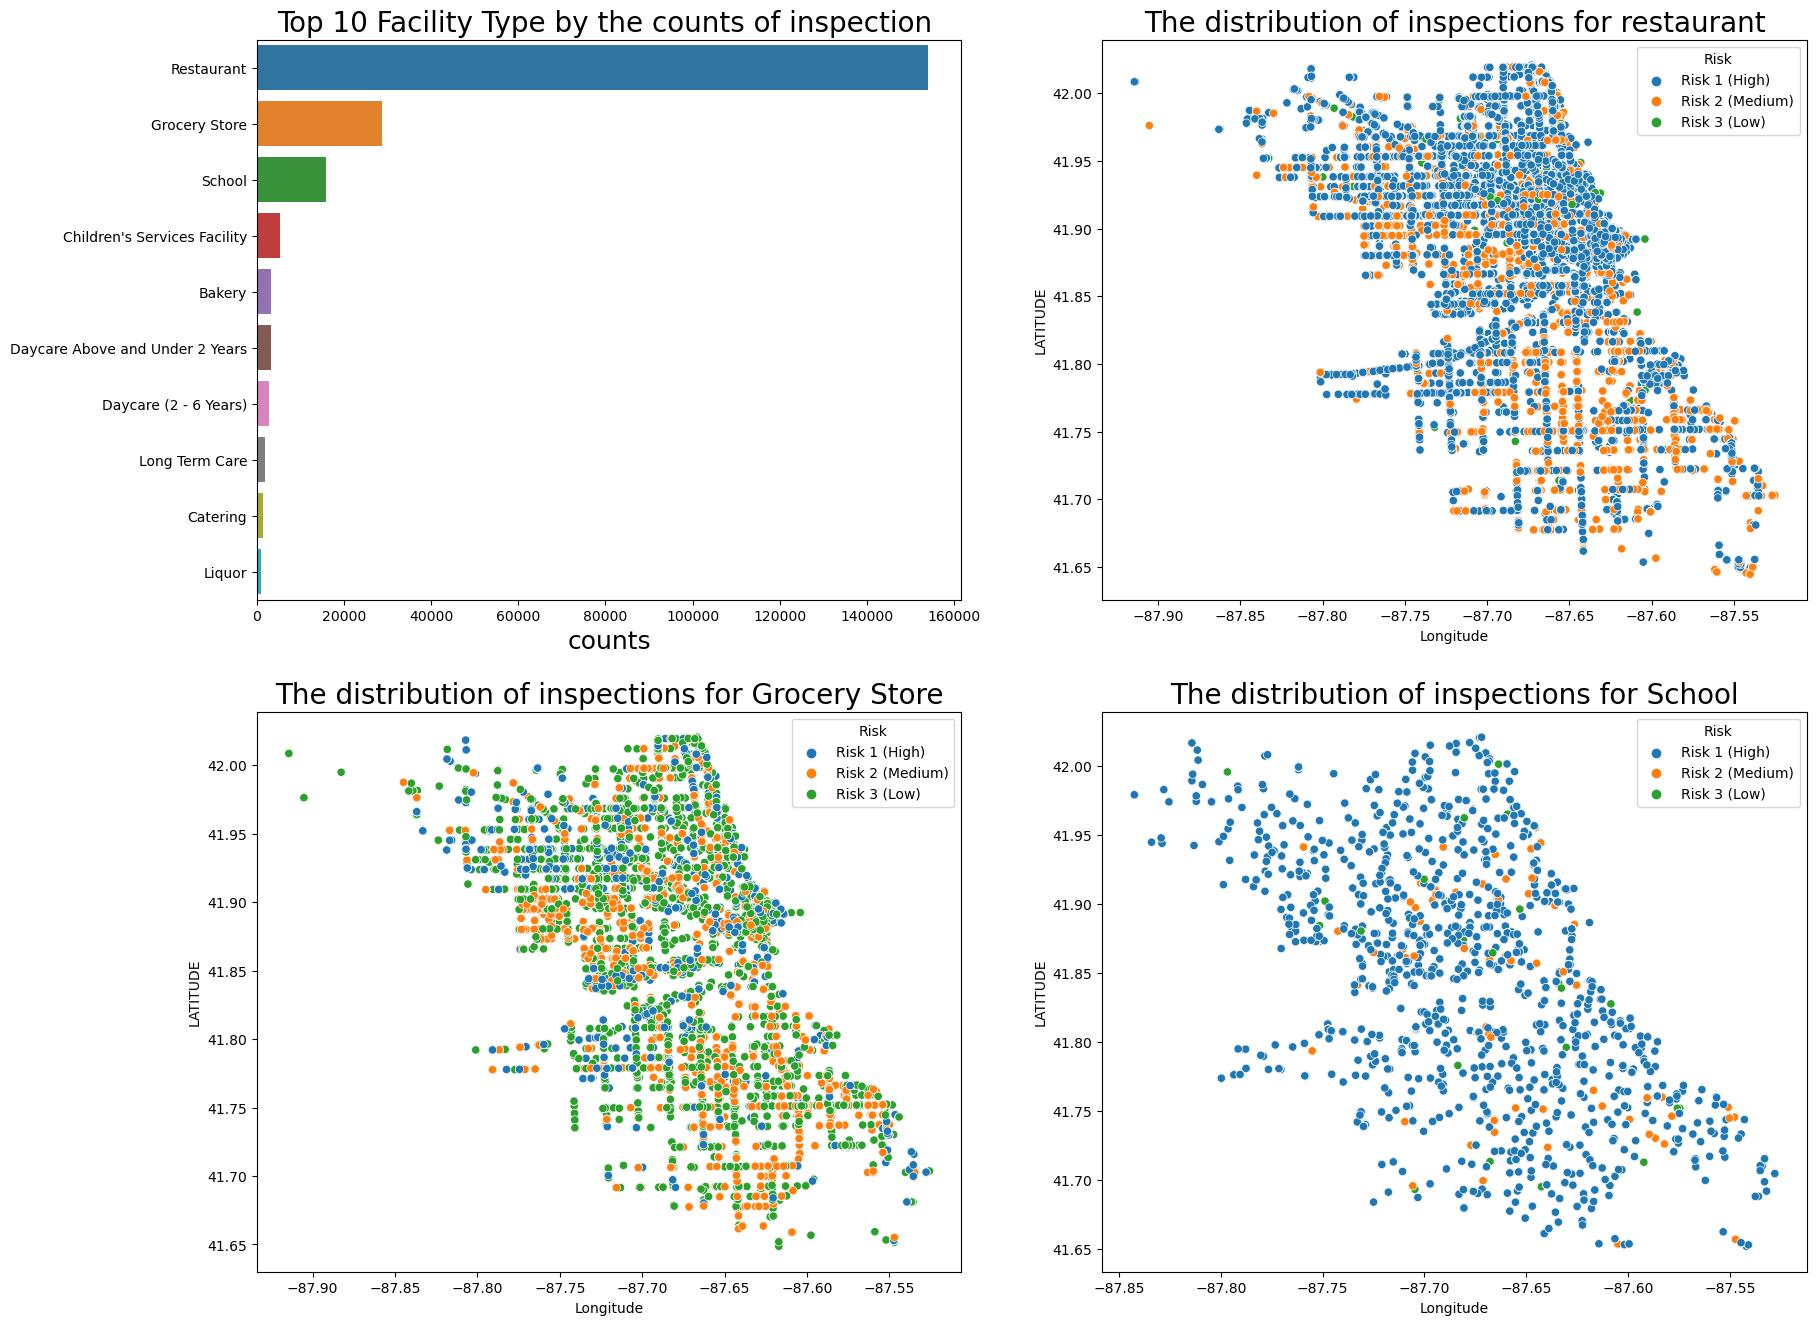

In [14]:
fig,ax=plt.subplots(2,2,figsize=(20,16))
y=df['Facility Type'].value_counts()[:10].index
x=df['Facility Type'].value_counts()[:10]
sns.barplot(x=x,y=y,ax=ax[0,0])
ax[0,0].set_title("Top 10 Facility Type by the counts of inspection ",size=20)
ax[0,0].set_xlabel('counts',size=18)
ax[0,0].set_ylabel('')

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk',hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'] ,data=df[df['Facility Type']=='Restaurant'], ax=ax[0,1])
ax[0,1].set_title("The distribution of inspections for restaurant",size=20)
ax[0,1].set_xlabel('Longitude')
ax[0,1].set_ylabel('LATITUDE')

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk' ,hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'],data=df[df['Facility Type']=='Grocery Store'], ax=ax[1,0])
ax[1,0].set_title("The distribution of inspections for Grocery Store",size=20)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('LATITUDE')

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk',hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'] ,data=df[df['Facility Type']=='School'], ax=ax[1,1])
ax[1,1].set_title("The distribution of inspections for School",size=20)
ax[1,1].set_xlabel('Longitude')
ax[1,1].set_ylabel('LATITUDE')

In [15]:
x = df['Risk'].value_counts().index.values.astype('str')
y = df['Risk'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(df))]


trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Type of Risk Count',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Risk'))
fig=dict(data=[trace1], layout=layout)
iplot(fig)

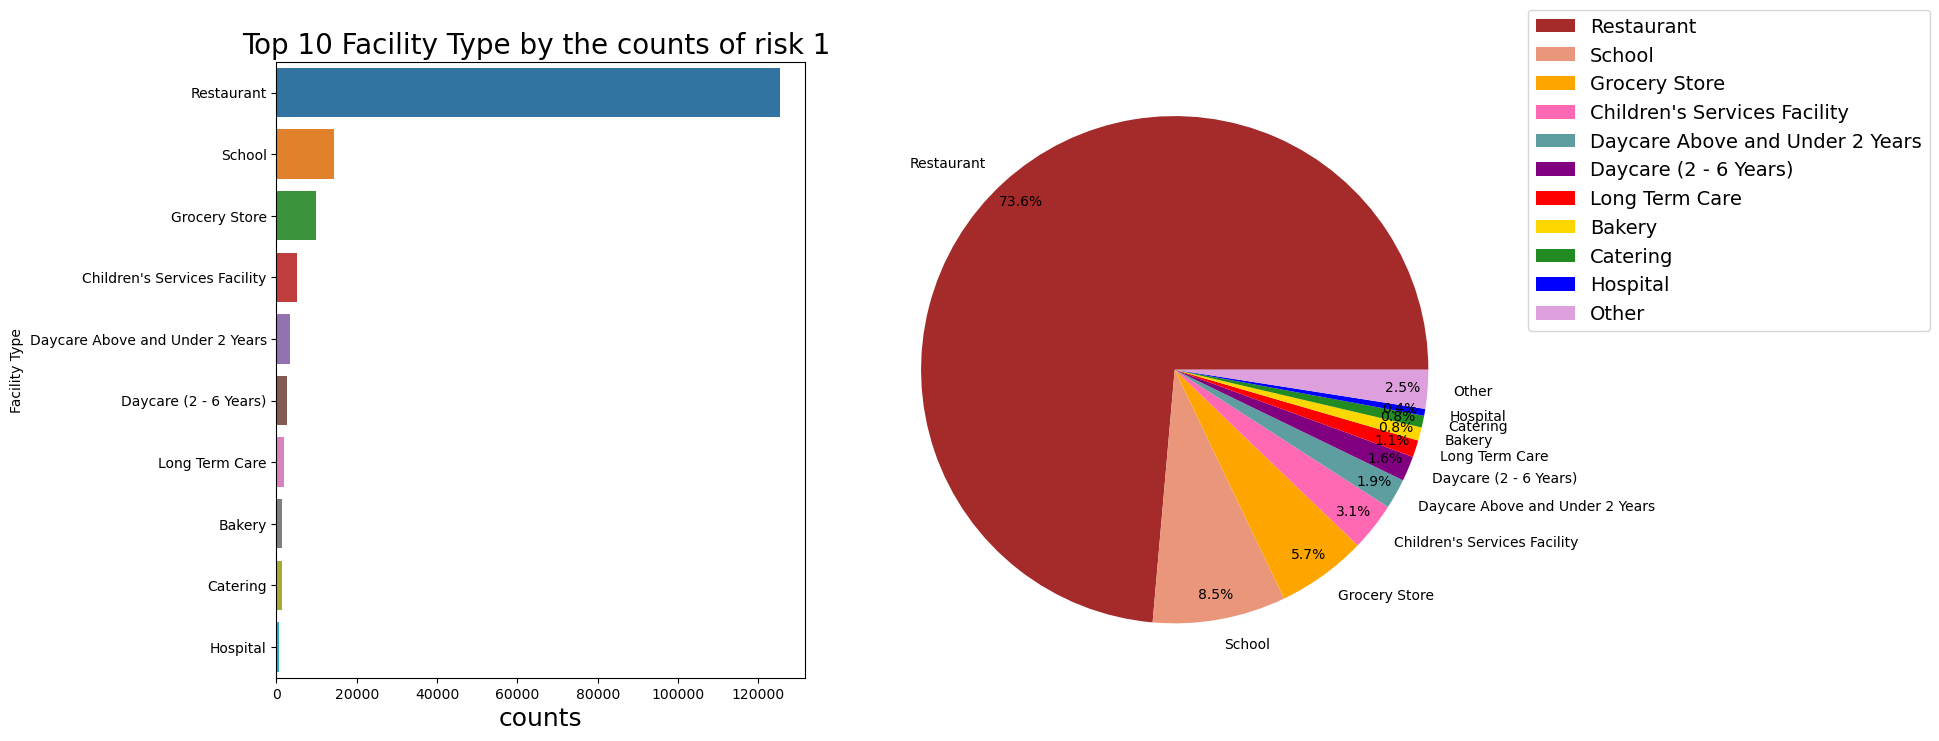

In [16]:
data_risk1=df[df.Risk=='Risk 1 (High)']
fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=data_risk1['Facility Type'].value_counts()[:10],y=data_risk1['Facility Type'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facility Type by the counts of risk 1 ",size=20)
ax[0].set_xlabel('counts',size=18)


count=data_risk1.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False)
groups=list(data_risk1.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False).index[:10])
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
ax[1].set_ylabel('')
ax[1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,1.2))

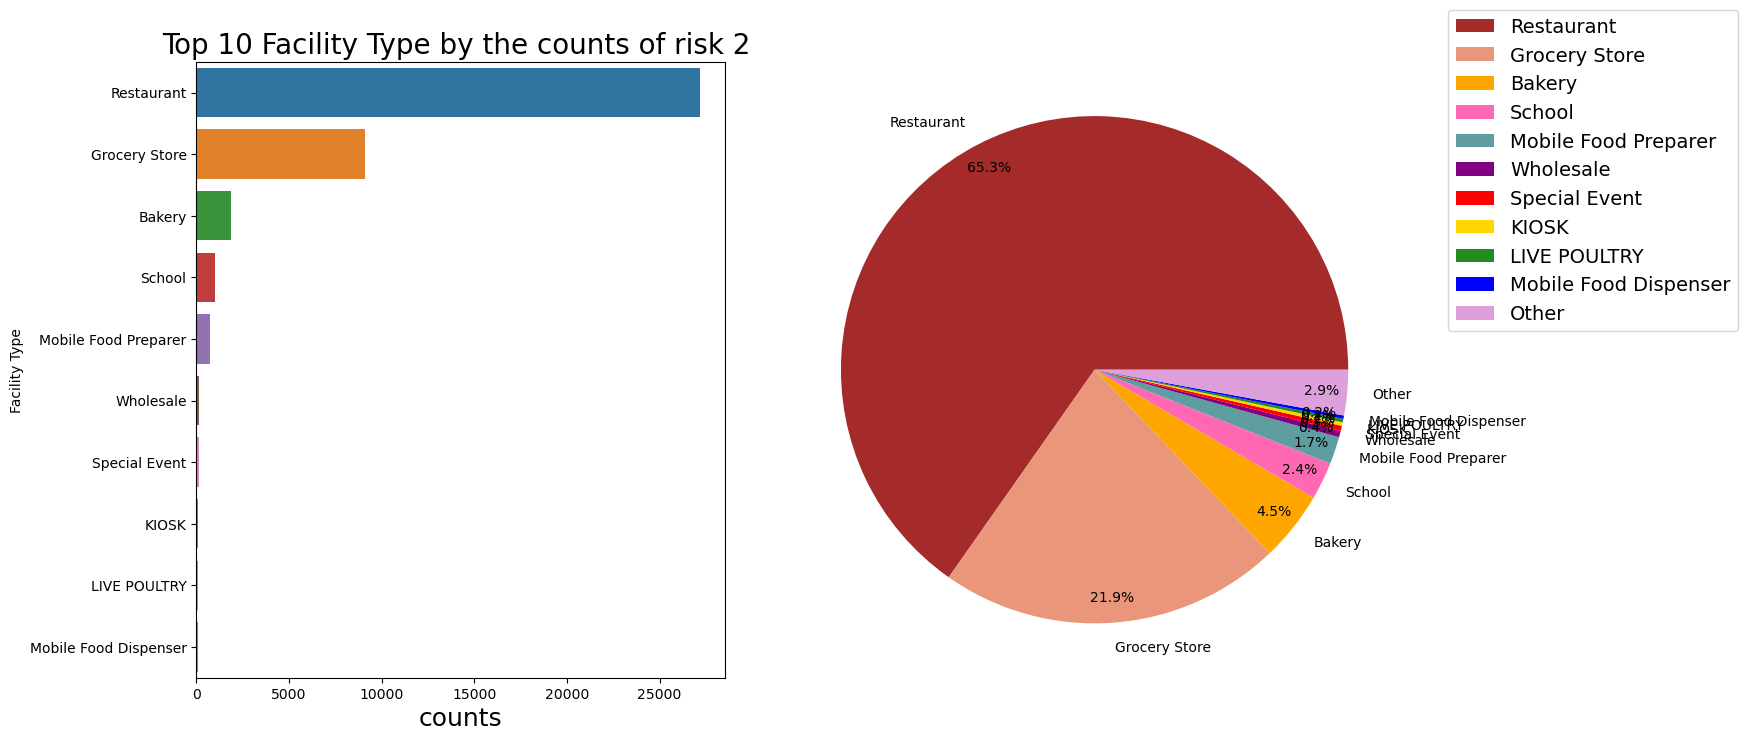

In [17]:
data_risk2=df[df.Risk=='Risk 2 (Medium)']

fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=data_risk2['Facility Type'].value_counts()[:10],y=data_risk2['Facility Type'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facility Type by the counts of risk 2 ",size=20)
ax[0].set_xlabel('counts',size=18)


count=data_risk2.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False)
groups=list(data_risk2.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False).index[:10])
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
ax[1].set_ylabel('')
ax[1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,1.2))

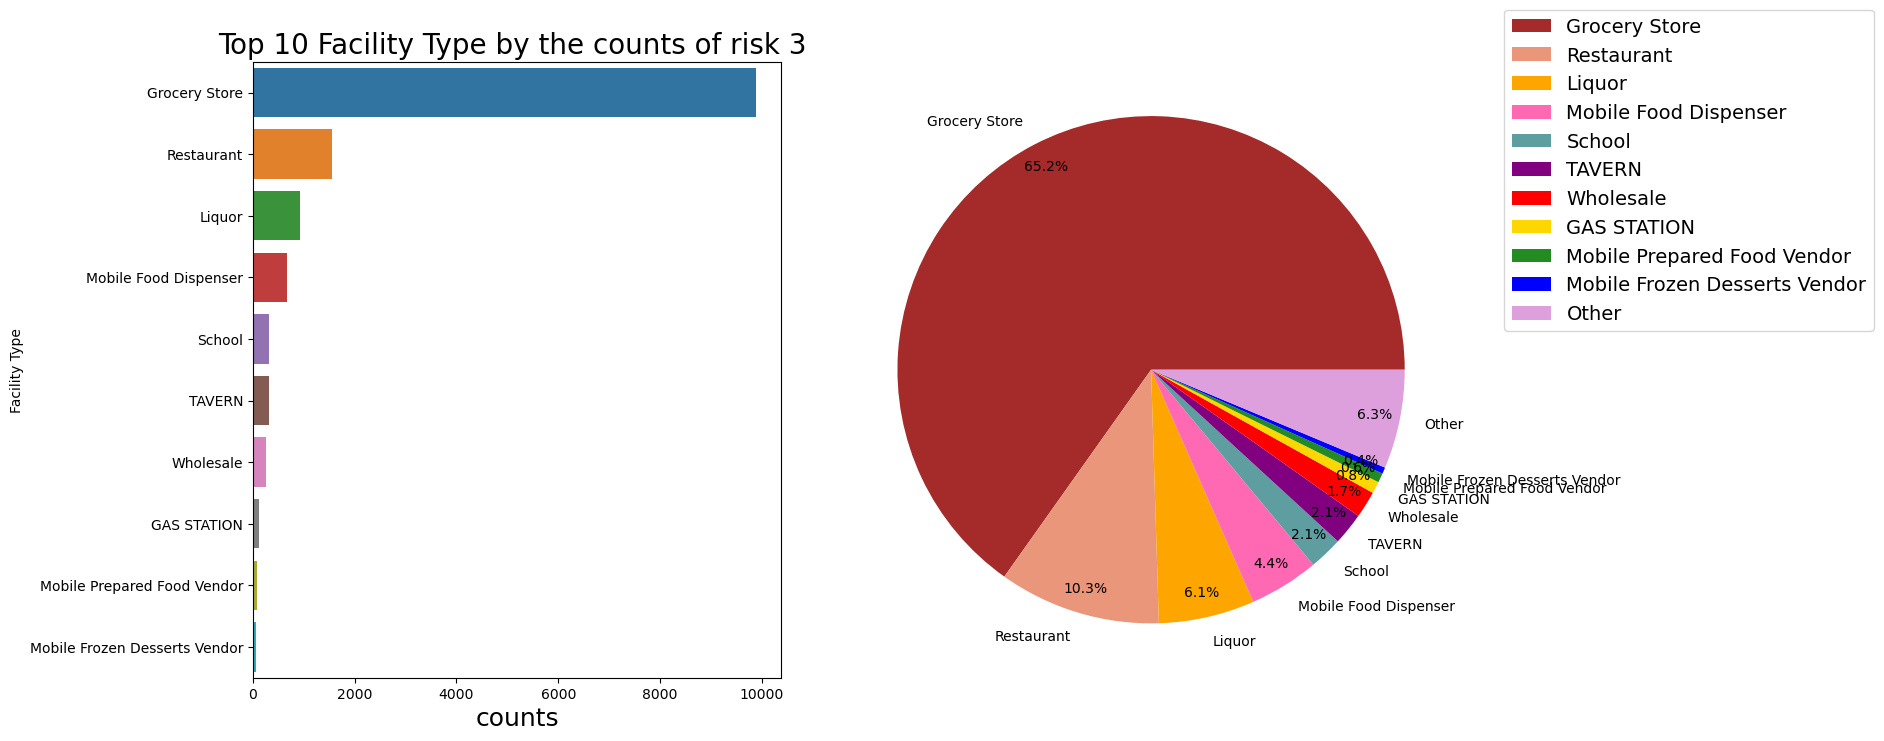

In [18]:
data_risk3=df[df.Risk=='Risk 3 (Low)']

fig,ax=plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=data_risk3['Facility Type'].value_counts()[:10],y=data_risk3['Facility Type'].value_counts()[:10].index,ax=ax[0])
ax[0].set_title("Top 10 Facility Type by the counts of risk 3 ",size=20)
ax[0].set_xlabel('counts',size=18)


count=data_risk3.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False)
groups=list(data_risk3.groupby(['Facility Type'])['Inspection ID'].agg('count').sort_values(ascending=False).index[:10])
counts=list(count[:10])
counts.append(count.agg(sum)-count[:10].agg('sum'))
groups.append('Other')
type_dict=pd.DataFrame({"group":groups,"counts":counts})
clr1=('brown','darksalmon','orange','hotpink','cadetblue','purple','red','gold','forestgreen','blue','plum')
type_dict.plot(kind='pie', y='counts', labels=groups,colors=clr1,autopct='%1.1f%%', pctdistance=0.9, radius=1.2,ax=ax[1])
ax[1].set_ylabel('')
ax[1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,1.2))

In [19]:
x = df['Results'].value_counts().index.values.astype('str')
y = df['Results'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(df))]


trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Inspectation Results Count',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Results'))
fig=dict(data=[trace1], layout=layout)
iplot(fig)

In [20]:
df.groupby(['Risk', 'Results']).size().reset_index(name="Frequency")


,Risk,Results,Frequency
0,All,Fail,5
1,Risk 1 (High),Fail,37394
2,Risk 1 (High),Pass,102159
3,Risk 1 (High),Pass w/ Conditions,31009
4,Risk 2 (Medium),Fail,9512
5,Risk 2 (Medium),Pass,24731
6,Risk 2 (Medium),Pass w/ Conditions,7501
7,Risk 3 (Low),Fail,4601
8,Risk 3 (Low),Pass,8951
9,Risk 3 (Low),Pass w/ Conditions,1784


<Axes: xlabel='Results', ylabel='Risk'>

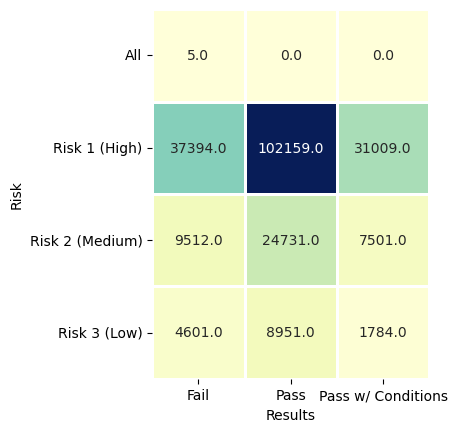

In [21]:
sns.heatmap(pd.crosstab([df.Risk], [df.Results]),
            cmap="YlGnBu", annot=True, fmt=".1f", linewidths=1.0, square=1, cbar=False)

Text(0, 0.5, 'LATITUDE')

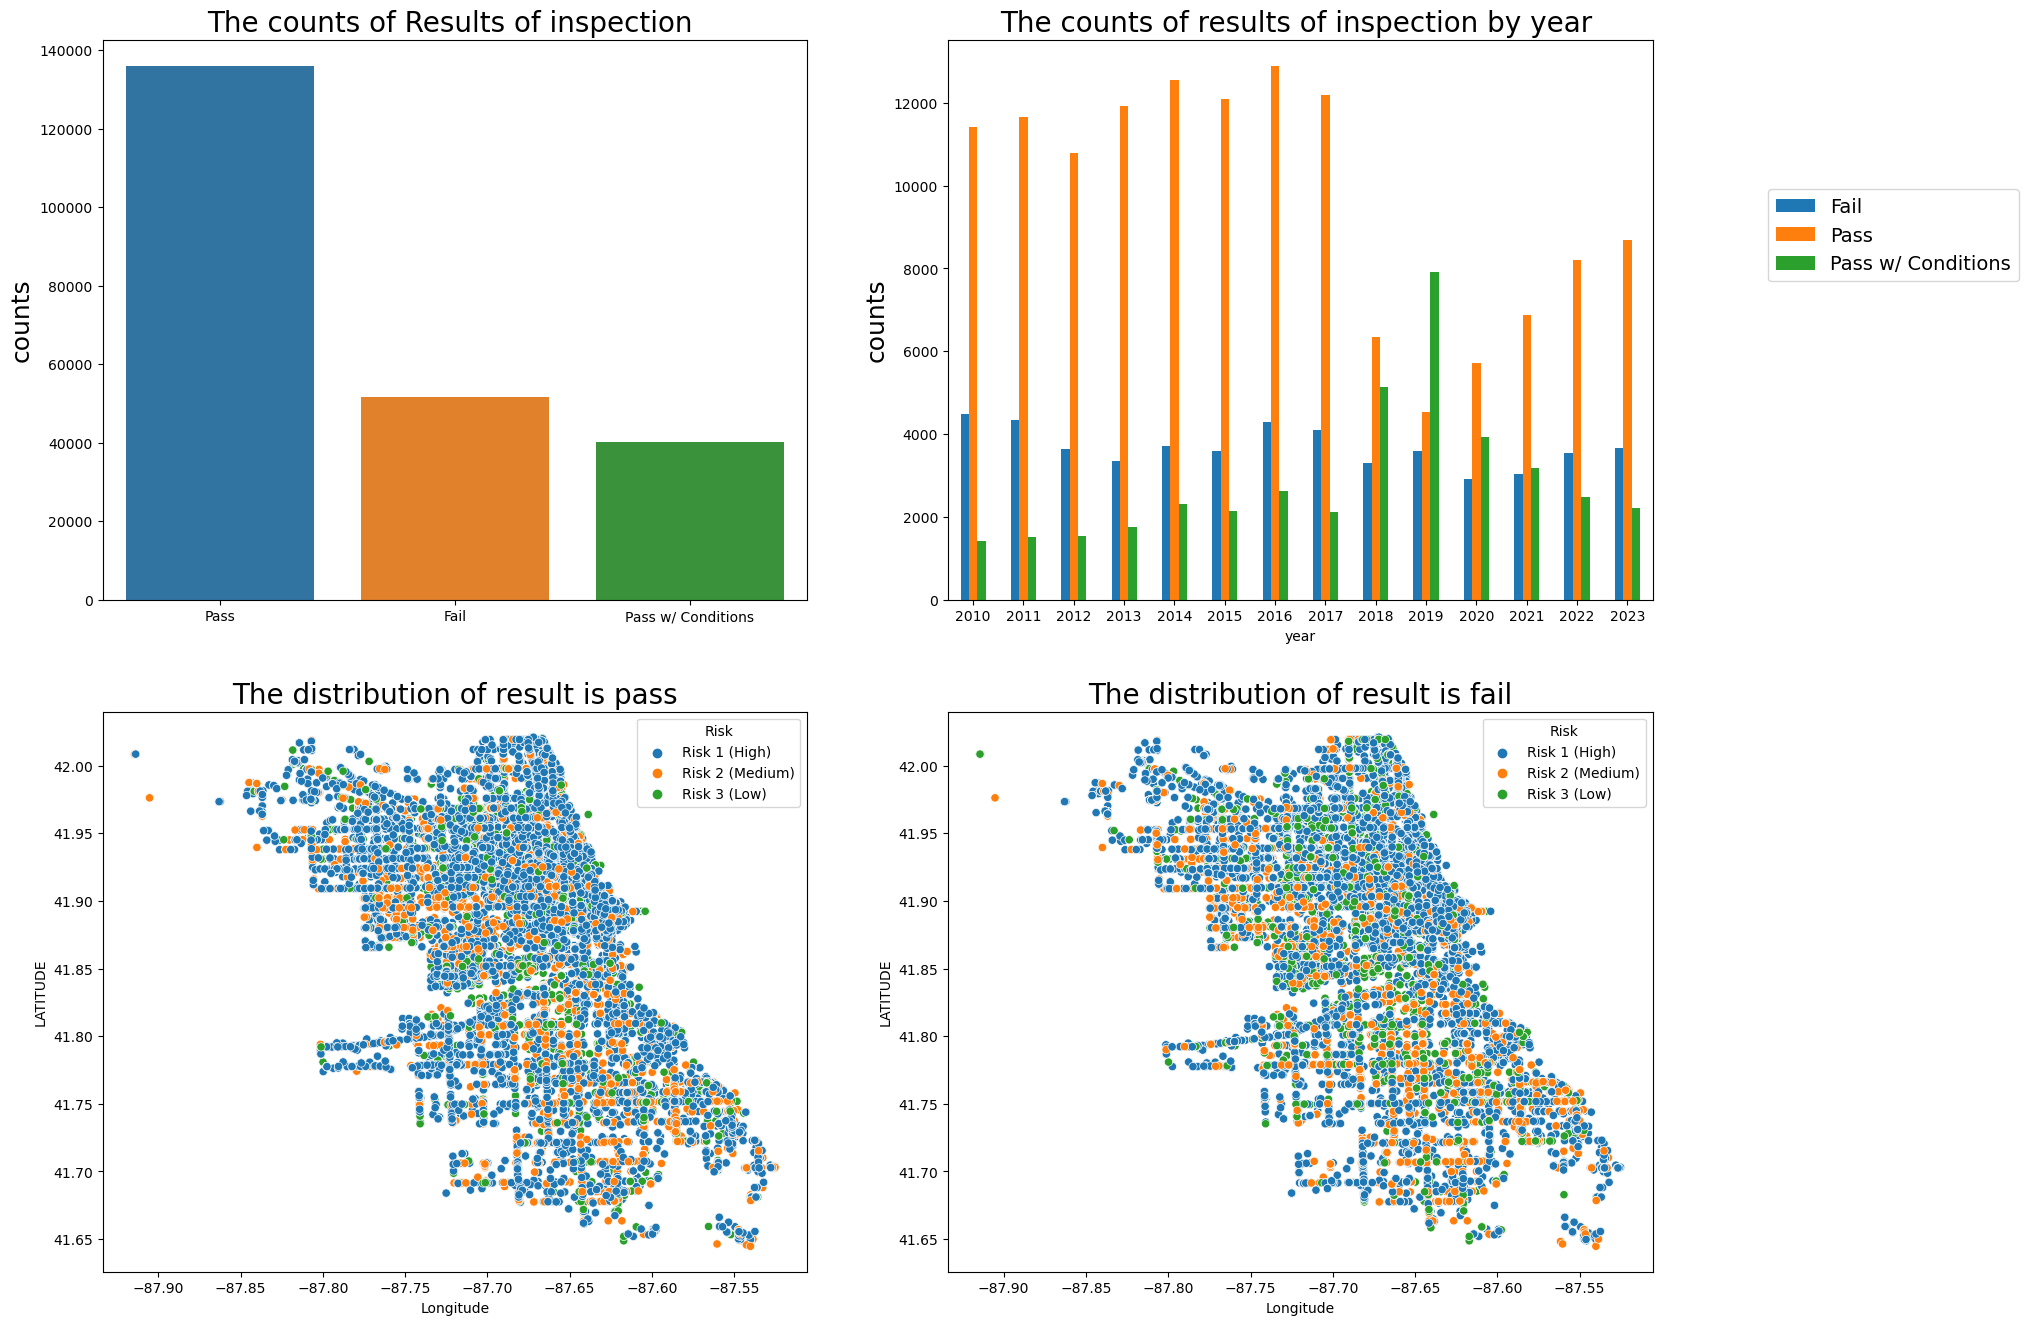

In [22]:
fig,ax=plt.subplots(2,2,figsize=(20,16))
x=df.Results.value_counts().index
y=df.Results.value_counts()
sns.barplot(x=x,y=y,ax=ax[0,0])
ax[0,0].set_title("The counts of Results of inspection ",size=20)
ax[0,0].set_ylabel('counts',size=18)
ax[0,0].set_xlabel('')

df.groupby(['Results','year'])['Inspection ID'].agg('count').unstack('Results').plot(kind='bar',ax=ax[0,1])
ax[0,1].tick_params(axis='x',labelrotation=360)
ax[0,1].legend(loc=0, ncol=1, fontsize=14,bbox_to_anchor=(1.15,0.75))
ax[0,1].set_title("The counts of results of inspection by year ",size=20)
ax[0,1].set_ylabel('counts',size=18)

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk' ,hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'],data=df[df.Results=='Pass'], ax=ax[1,0])
ax[1,0].set_title("The distribution of result is pass",size=20)
ax[1,0].set_xlabel('Longitude')
ax[1,0].set_ylabel('LATITUDE')

sns.scatterplot(x='Longitude',y='Latitude',hue='Risk',hue_order=['Risk 1 (High)','Risk 2 (Medium)','Risk 3 (Low)'] ,data=df[df.Results=='Fail'], ax=ax[1,1])
ax[1,1].set_title("The distribution of result is fail",size=20)
ax[1,1].set_xlabel('Longitude')
ax[1,1].set_ylabel('LATITUDE')

In [23]:
df['Restaurant'] = (df['Facility Type'].values == 'Restaurant').astype('int')



<Axes: xlabel='Risk', ylabel='Restaurant'>

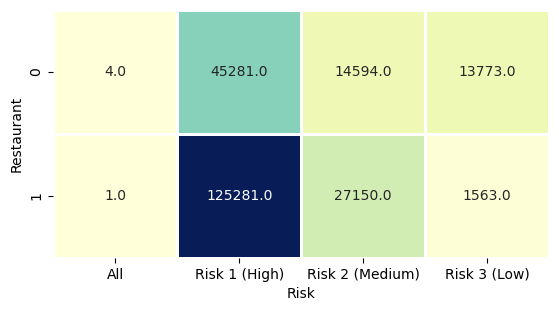

In [24]:
sns.heatmap(pd.crosstab([df.Restaurant], [df.Risk]),
            cmap="YlGnBu", annot=True, fmt=".1f", linewidths=1.0, square=1, cbar=False)

<Axes: xlabel='Results', ylabel='Restaurant'>

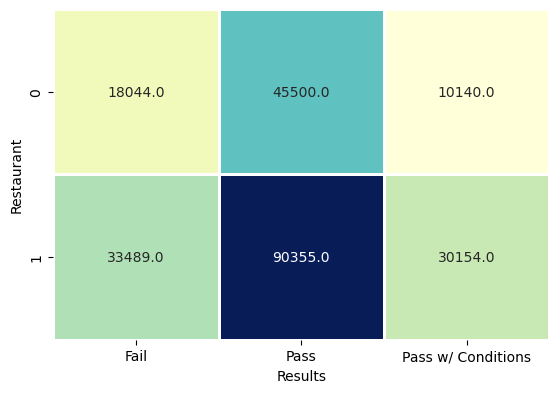

In [25]:
sns.heatmap(pd.crosstab([df.Restaurant], [df.Results]),
            cmap="YlGnBu", annot=True, fmt=".1f", linewidths=1.0, square=1, cbar=False)

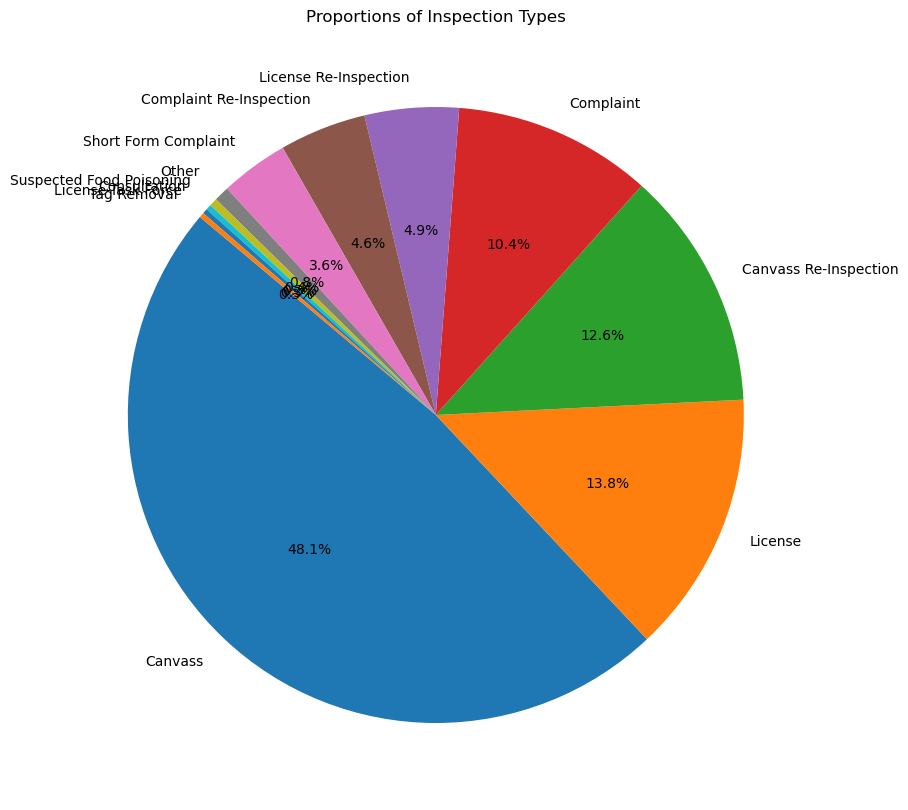

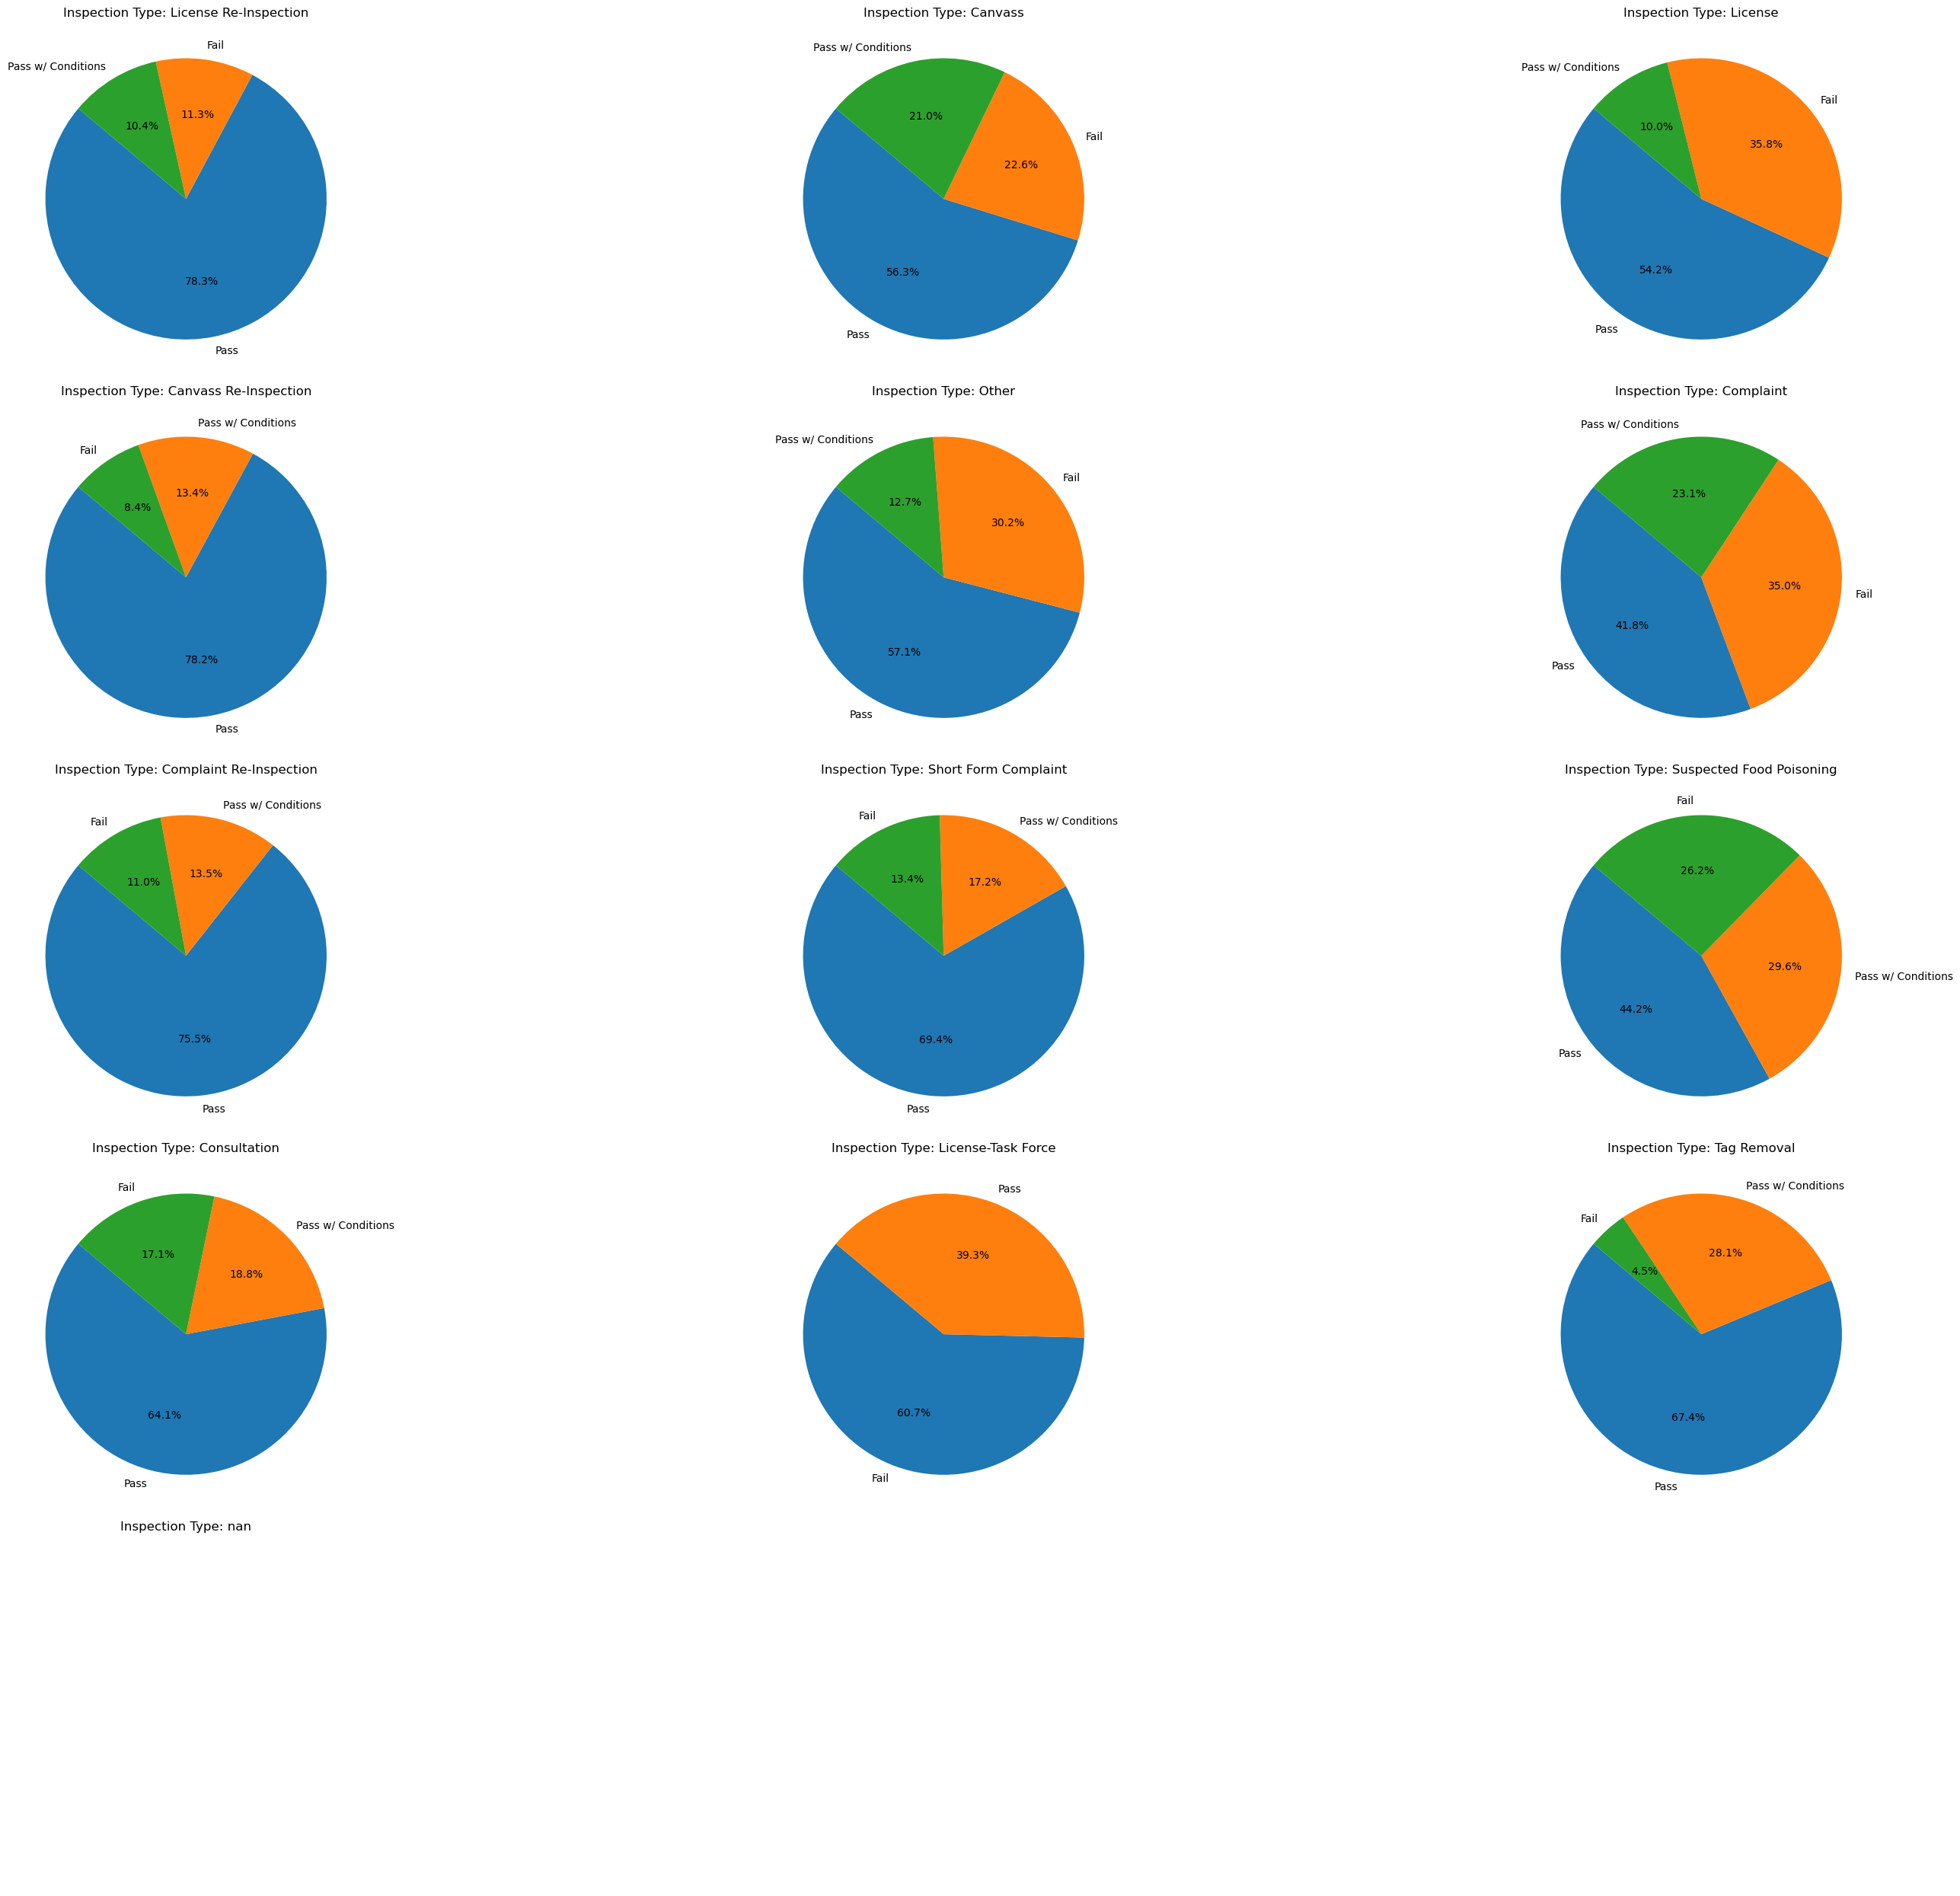

In [26]:
inspection_type_counts = df['Inspection Type'].value_counts()
rare_types = inspection_type_counts[inspection_type_counts <= 500].index
df['Inspection Type'] = df['Inspection Type'].apply(lambda x: 'Other' if x in rare_types else x)
inspection_type_counts_updated = df['Inspection Type'].value_counts()

plt.figure(figsize=(10, 10))
plt.pie(inspection_type_counts_updated, labels=inspection_type_counts_updated.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportions of Inspection Types')
plt.show()

unique_inspection_types = df['Inspection Type'].unique()

n_types = len(unique_inspection_types)
n_cols = 3
n_rows = -(-n_types // n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, inspection_type in enumerate(unique_inspection_types):
    type_data = df[df['Inspection Type'] == inspection_type]
    
    result_counts = type_data['Results'].value_counts(normalize=True)
    
    axes[i].pie(result_counts, labels=result_counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'Inspection Type: {inspection_type}')

if n_types % n_cols != 0:
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [27]:
df['Violations'] = df['Violations'].astype(str)
df[df["Violations"] == "nan"]

,Inspection ID,DBA Name,AKA Name,license,Facility Type,Risk,Address,City,State,Zip,...,Inspection Type,Results,Violations,Latitude,Longitude,Location,year,month,day,Restaurant
4,2586837,SEGNATORE,SEGNATORE,2786131.0,Restaurant,Risk 1 (High),1001 N CALIFORNIA AVE,CHICAGO,IL,60622.0,...,Canvass,Pass,nan,41.899331,-87.696645,"(41.899330918472295, -87.69664492473737)",2023,12,13,1
6,2586806,LEE'S UNLEADED BLUES,LEE'S UNLEADED BLUES,2924591.0,TAVERN,Risk 3 (Low),7401 S SOUTH CHICAGO AVE,CHICAGO,IL,60619.0,...,License Re-Inspection,Pass,nan,41.760530,-87.597924,"(41.76053016467859, -87.59792396776683)",2023,12,12,0
7,2586791,DAWN,DAWN,2939215.0,Restaurant,Risk 1 (High),1642 E 56TH ST,CHICAGO,IL,60637.0,...,License,Fail,nan,41.793514,-87.584947,"(41.79351407619528, -87.58494662001773)",2023,12,12,1
8,2586777,TACOS EL PASTOR 53,TACOS EL PASTOR 53,2938294.0,Restaurant,Risk 3 (Low),5319 S HYDE PARK BLVD,CHICAGO,IL,60615.0,...,License,Pass,nan,41.799003,-87.583893,"(41.799003255757576, -87.58389265837322)",2023,12,12,1
9,2586718,HONEYBRAINS,HONEYBRAINS,2939444.0,Restaurant,Risk 3 (Low),700 N MICHIGAN AVE,CHICAGO,IL,60611.0,...,License,Pass,nan,41.894980,-87.624400,"(41.89497951109999, -87.62439997045513)",2023,12,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264871,124372,FRAPPE,FRAPPE,1675511.0,NaN,Risk 1 (High),4431 N MILWAUKEE AVE,CHICAGO,IL,60630.0,...,Other,Pass,nan,41.961554,-87.755099,"(41.96155384444727, -87.75509939573654)",2010,3,12,0
264872,229302,ROBINSON RIBS,ROBINSON RIBS,1301095.0,NaN,Risk 1 (High),500 W MADISON ST,CHICAGO,IL,60661.0,...,Other,Pass,nan,41.881994,-87.639759,"(41.88199433820508, -87.6397586848809)",2010,3,12,0
264876,98401,SALLY'S LOUNGE,SALLY'S LOUNGE,16060.0,TAVERN,Risk 3 (Low),3759 N WESTERN AVE,CHICAGO,IL,60618.0,...,Canvass Re-Inspection,Pass,nan,41.950290,-87.688211,"(41.95029040267561, -87.688211015391)",2010,3,9,0
264878,231211,T TASTY HOUSE,T TASTY HOUSE,2017359.0,Restaurant,Risk 1 (High),2002 S WENTWORTH AVE,CHICAGO,IL,60616.0,...,License Re-Inspection,Pass,nan,41.855282,-87.631993,"(41.85528170377401, -87.63199264229414)",2010,2,10,1


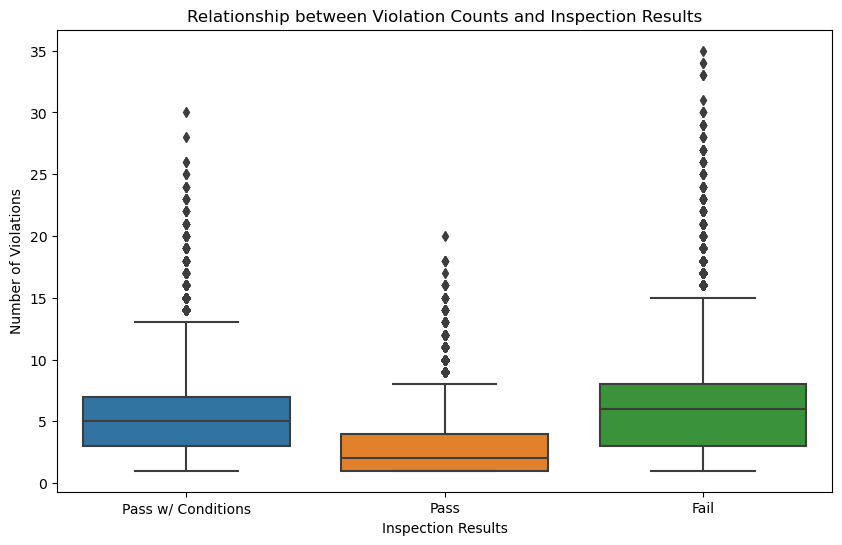

In [28]:
df['Violation Count'] = df['Violations'].apply(lambda x: len(str(x).split('|')))

# Visualize the relationship between Violation Count and Results
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Results'], y=df['Violation Count'])
plt.title('Relationship between Violation Counts and Inspection Results')
plt.xlabel('Inspection Results')
plt.ylabel('Number of Violations')
plt.show()

In [29]:
df['Violations'] = df['Violations'].astype(str)
df = df[df.Violations != "nan"]
df.shape

(190884, 22)

In [30]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder() 
df['DBA Name'] = le.fit_transform(df['DBA Name'])
df['Facility Type'] = df['Facility Type'].astype(str)
df['Facility Type'] = le.fit_transform(df['Facility Type'])
df['Address'] = le.fit_transform(df['Address'])
df['Zip'] = le.fit_transform(df['Zip'])
df['Results'] = (df['Results'].values == 'Fail').astype('int')
df['Violations'] = le.fit_transform(df["Violations"])
df['Inspection Type'] = le.fit_transform(df["Inspection Type"])
df['Risk'] = le.fit_transform(df['Risk'])

In [31]:
df = df.drop(['Inspection ID', 'AKA Name', 'City', 'State', 'Inspection Date', 'Location'], axis = 1)

In [35]:
# x = df['Results'].value_counts().index
# y = df['Results'].value_counts().values

# trace2 = go.Bar(
#      x=x ,
#      y=y,
#      marker=dict(
#          color=y,
#          colorscale = 'Viridis',
#          reversescale = True
#      ),
#      name="Imbalance",    
#  )
# layout = dict(
#      title="Data imbalance - Results",
#      #width = 900, height = 500,
#      xaxis=go.layout.XAxis(
#      automargin=True),
#      yaxis=dict(
#          showgrid=False,
#          showline=False,
#          showticklabels=True,
#  #         domain=[0, 0.85],
#      ), 
# )
# fig1 = go.Figure(data=[trace2], layout=layout)
# iplot(fig1)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Decision Tree
X = df.drop('Results', axis=1)
y = df['Results']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

predictions = tree_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.8471169629448538


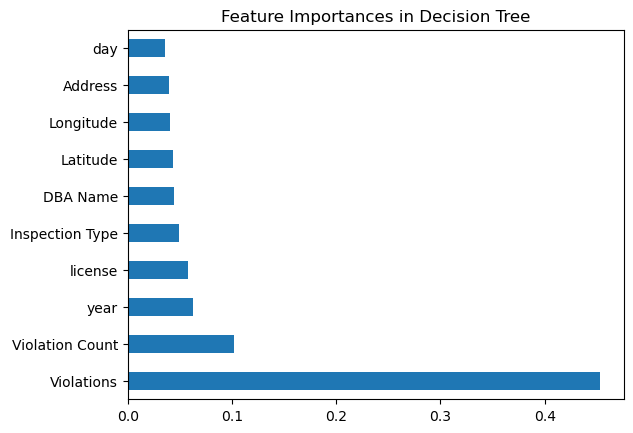

[0.04427511 0.0582248  0.00984091 0.00513346 0.03978818 0.02612732
 0.04943987 0.45313817 0.04296892 0.0405883  0.062149   0.02677936
 0.03572046 0.00420967 0.10161647]
Index(['DBA Name', 'license', 'Facility Type', 'Risk', 'Address', 'Zip',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'year',
       'month', 'day', 'Restaurant', 'Violation Count'],
      dtype='object')


In [34]:
feature_importances = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances in Decision Tree')
plt.show()
print(tree_model.feature_importances_)
print(X.columns)